<h1><center> BioE245 Final project Part2: Classification </h1></center>
<h2><center> Efficacy Comparison of various model for Peripheral blood mononuclear cells classification using transcriptomics data </h2></center>
    
## Hugo Hakem Meng BioE 23-24'

### Acknowledgement
This work stands as the final project for the BioE245 class taught in Spring2024 by Professor. Liana Lareau, and GSIs. Michael Herschl, Amy Lu.

# 0) Some background and motivation
Peripheral blood mononuclear cells (PBMCs) are a group of different cell types in your blood, a subset of what we call white blood cells. They include many important parts of your immune system: T cells, B cells, natural killer cells, and so on. These cells are responsible for your innate and adaptive immune responses. When you get infected or vaccinated, they kick into high gear. In different situations, or with different diseases, the mix of different cell types shifts and so does the gene expression within one type of cell. PBMCs can be isolated very easily from patient blood samples, just by spinning the blood in a centrifuge that separates different cell types by weight. So, looking at these cells can be very informative.

For this present work, two dataset has been furnished: 
+ labels.csv stores the association between a cell barcode and a cell type label.
+ processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.
    
The goal of this part of the project is to classify the cell using supervised machine larning method. 

This Notebook is partitionned as follow.
1. [Data Preprocessing](#PrePro)
2. [Model Implementation](#Model)
   1. [Decision Trees](#DecTrees)
        + [XGBoost](#XGBoost)
        + [RandomForest](#RandomForest)
   2. [Bayes Model](#Bayes)
        + [Gaussian Naive Bayes](#Gaussian)
        + [Bernouilli Naive Bayes](#Bernouilli)
        + [Multivariate Gaussian Bayes](#MultiGaussian)
   3. [Feed Forward Neural Network](#FFNN)
3. [Conclusion](#Conclusion)


To run the present Notebook, here is a list of command to run sequentially in your environment and which will install the package required. 

```conda install ipykernel conda-forge -y```
```conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia```
```conda install pandas matplotlib seaborn tqdm -c conda-forge -y```
```conda install -c conda-forge py-xgboost```
    
**Please Note: for each model recquiring some fine-tuning, several parameters has been tested and only the best architecture are displayed** 

# 1) Data Preprocessing <a id="PrePro"></a>

In [371]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [289]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [290]:
labels_pd.head()

,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic
2,AACACGTGGTCTTT-1,CD56+ NK
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,Dendritic


In [291]:
counts_pd.head()

,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490


**Let's check the class imbalance of the data set**

In [292]:
labels_pd.groupby("bulk_labels").size() * 100 / labels_pd.shape[0]

bulk_labels
CD14+ Monocyte                  18.428571
CD19+ B                         13.571429
CD34+                            1.857143
CD4+/CD25 T Reg                  9.714286
CD4+/CD45RA+/CD25- Naive T       1.142857
CD4+/CD45RO+ Memory              2.714286
CD56+ NK                         4.428571
CD8+ Cytotoxic T                 7.714286
CD8+/CD45RA+ Naive Cytotoxic     6.142857
Dendritic                       34.285714
dtype: float64

In this data set, **not all class are equivalent in term of proportion** which means that specific attention must be given to the classifier architecture to deal with this imbalance. Otherwise the classifier will be biased to predict the class with larger population proportion. **For this reason weight will be associated to each class.** Note however that using class weight will not necessarly lead to classification improvement as the **imbalance remain moderate.** Indeed, a data set is commonly said to be severely imbalanced for class proportion less than 1%. 

In [293]:
class_perc = labels_pd.groupby("bulk_labels").size() / labels_pd.shape[0]
class_weight = class_perc.min() / class_perc
class_weight = class_weight[categories].values
class_weight

array([0.0620155 , 0.03333333, 0.25806452, 0.11764706, 0.08421053,
       0.14814815, 0.42105263, 0.18604651, 1.        , 0.61538462])

In [294]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


+ **The cell-type are now One-hot encoded.**

+ **labels and the counts are shuffled together.**

+ **A split into train and test sets (80:20 split) is performed.**

In [295]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


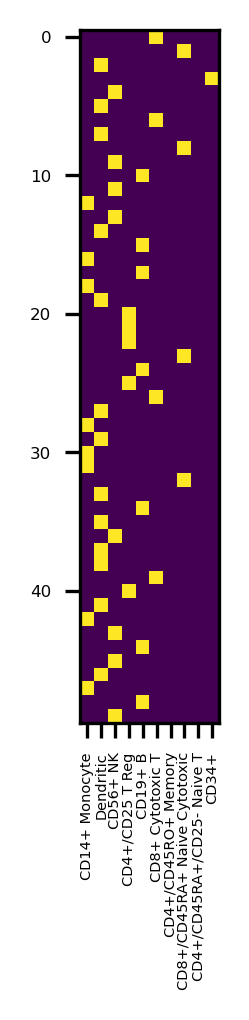

In [296]:
#Visualize the One-hot encoded Prediction Labels
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])
plt.xticks(np.arange(len(categories)), categories, rotation=90, fontsize=3.5)
plt.yticks(fontsize=4)
plt.show()

# 2) Model Implementation <a id="Model"></a>
Let's create a dict gathering every result

In [297]:
Train_dict = {}
Test_dict = {}

## A) Decision Trees <a id="DecTrees"></a>

Decision Trees are the first model tested as they are usually easy to fine-tune and they can lead high accuracy in classification task. 

### a) XGBoost <a id="XGBoost"></a>

XGBoost is an optimized implementation of a Gradient Boosting Decision Trees (GBDT). GBDT is usually the most powerful decision trees algorithm as it is specifically designed to reclassify wrongly classify data. However, it may lead to overfitting on the training set. 

In [300]:
def Grid_search_XGBoost(X_train, X_test, y_train, y_test, class_weight, eval_metric=accuracy_score, printing=True,
                        XGB_param={"n_estimators": 100, "max_depth":5, "subsample":0.9, "colsample_bytree":0.4,
                                   "gamma":0,
                                   "reg_alpha":0,
                                   "reg_lambda":0,
                                   "eta":1e-2,
                                   "min_child_weight":2}):
    
    
    """
    Return Train accuracy and Test Accuracy for the XGBoost model. 
    
    Parameters
    ---------
    X_train(ndarray):(n_samples, n_feat) features array, training split
    X_test(ndarray):(n_samples, n_feat) features array, test split
    y_train(ndarray):(n_samples, n_class) label array, must be one-hot-encoded, training split
    y_test(ndarray):(n_samples, n_class) label array, must be one-hot-encoded, test split
    class_weight(ndarray):(n_class,) weight for each class 
    eval_metric(sklearn_function): must be 'accuracy_score' or 'roc_auc_score' 
    printing(bool): whether or not to print the result 
    XGB_param(dict): must have the same shape as the one provided as default value. 

    Output
    -------
    train_acc_all: training accuracy. 
    test_acc_all: test accuracy. 
    """

    
    xgbc = XGBClassifier(n_estimators=XGB_param["n_estimators"], 
                         max_depth=XGB_param["max_depth"], 
                         subsample=XGB_param["subsample"], 
                         colsample_bytree=XGB_param["colsample_bytree"], 
                         reg_alpha=XGB_param["reg_alpha"],
                         reg_lambda=XGB_param["reg_lambda"],
                         eval_metric=eval_metric, 
                         gamma=XGB_param["gamma"],
                         eta=XGB_param["eta"],
                         min_child_weight=XGB_param["min_child_weight"],
                         objective="multi:softmax",
                         num_class=10)
    
    if class_weight is None:
        xgbc.fit(X_train, y_train.argmax(axis=1))
    else: 
        sample_weight = (y_train * class_weight).max(axis=1)
        xgbc.fit(X_train, y_train.argmax(axis=1), sample_weight=sample_weight)
        
    if eval_metric == roc_auc_score:
        train_acc_all = roc_auc_score(y_train, xgbc.predict_proba(X_train), multi_class="ovr")
        test_acc_all = roc_auc_score(y_test, xgbc.predict_proba(X_test), multi_class="ovr")
    else: 
        train_acc_all = accuracy_score(y_train.argmax(axis=1), xgbc.predict(X_train))
        test_acc_all = accuracy_score(y_test.argmax(axis=1), xgbc.predict(X_test))
    if printing:
        print(f"Training accuracy: {train_acc_all:0.04f}")
        print(f"Test accuracy: {test_acc_all:0.04f}")
    return train_acc_all, test_acc_all

For Fine-tuning, please refer to __[XGBClassifier doc](https://xgboost.readthedocs.io/en/stable/parameter.html)__.
In particular to reduce overfitting: 

decrease: 
+ "n_estimators" (the number of trees)
+ "max_depth" (the maximum depth of each trees)
+ "subsample" (the fraction of data used for each trees)
+ "colsample_bytree" (the fraction of feature used for each trees)

or increase:
+ "reg_alpha" (l1 reg)
+ "reg_lambda" (l2 reg)
+ "eta" (learning rate)

Finally, 
+ "min_child_weight" is an important parameter which quantify the amount of weight needed in a node before to furhter partition. This is an interesting parameter especially when weight are given and can help increase the sensitivity to some class. 

Here are the best result obtained with playing with these parameter. Considering the amount of parameter, an actual grid search would probably have take a large amount of time and go beyond the scope of the project. 

In [302]:
train_acc_all, test_acc_all = Grid_search_XGBoost(X_train, X_test, y_train, y_test, 
                                                  class_weight=None, eval_metric=accuracy_score, printing=True,
                                                  XGB_param={"n_estimators": 100, "max_depth":5, 
                                                             "subsample":0.9, "colsample_bytree":0.4,
                                                             "gamma":0,
                                                             "reg_alpha":0,
                                                             "reg_lambda":0,
                                                             "eta":1e-2,
                                                             "min_child_weight":2})
Train_dict.update({"XGBoost (1)": train_acc_all})
Test_dict.update({"XGBoost (1)": test_acc_all})

Training accuracy: 0.9946
Test accuracy: 0.8214


In [304]:
train_acc_all, test_acc_all = Grid_search_XGBoost(X_train, X_test, y_train, y_test, 
                                                  class_weight=class_weight, eval_metric=accuracy_score, printing=True,
                                                  XGB_param={"n_estimators": 40, "max_depth":3, 
                                                             "subsample":0.9, "colsample_bytree":0.1,
                                                             "gamma":0,
                                                             "reg_alpha":0,
                                                             "reg_lambda":0,
                                                             "eta":1e-1,
                                                             "min_child_weight":1})

Train_dict.update({"XGBoost (2)": train_acc_all})
Test_dict.update({"XGBoost (2)": test_acc_all})

Training accuracy: 0.9179
Test accuracy: 0.8571


In [305]:
train_acc_all, test_acc_all = Grid_search_XGBoost(X_train, X_test, y_train, y_test, 
                                                  class_weight=None, eval_metric=accuracy_score, printing=True,
                                                  XGB_param={"n_estimators": 40, "max_depth":3, 
                                                             "subsample":0.9, "colsample_bytree":0.1,
                                                             "gamma":0,
                                                             "reg_alpha":0,
                                                             "reg_lambda":0,
                                                             "eta":1e-2,
                                                             "min_child_weight":2})
Train_dict.update({"XGBoost (3)": train_acc_all})
Test_dict.update({"XGBoost (3)": test_acc_all})

Training accuracy: 0.9357
Test accuracy: 0.8214


### b) Random Forest  <a id="RandomForest"></a>

Observing that XGBoost is overfitting, Random Forest is a common decision trees algorithm to address these issues. Adverserly, it may lead to underfitting.  

In [306]:
def Grid_search_RandomForest(X_train, X_test, y_train, y_test, printing=True,
                             RF_param={"n_estimators": 60, "max_depth":4, "min_samples_split":2, 
                                       "min_samples_leaf":3, "class_weight":"balanced", 
                                       "min_weight_fraction_leaf":0,
                                       "max_samples":None}):
    
    
    """
    Return Train accuracy and Test Accuracy for the RandoForest model. 
    
    Parameters
    ---------
    X_train(ndarray):(n_samples, n_feat) features array, training split
    X_test(ndarray):(n_samples, n_feat) features array, test split
    y_train(ndarray):(n_samples, n_class) label array, must be one-hot-encoded, training split
    y_test(ndarray):(n_samples, n_class) label array, must be one-hot-encoded, test split
    class_weight(ndarray):(n_class,) weight for each class 
    printing(bool): whether or not to print the result 
    RF_param(dict): must have the same shape as the one provided as default value. 

    Output
    -------
    train_acc_all: training accuracy. 
    test_acc_all: test accuracy. 
    """
    
    rf = RandomForestClassifier(n_estimators=RF_param["n_estimators"], 
                                  criterion="log_loss",
                                  max_depth=RF_param["max_depth"], 
                                  min_samples_split=RF_param["min_samples_split"], 
                                  min_samples_leaf=RF_param["min_samples_leaf"], 
                                  class_weight=RF_param["class_weight"],
                                  min_weight_fraction_leaf=RF_param["min_weight_fraction_leaf"],
                                  max_samples=RF_param["max_samples"])

    rf.fit(X_train, y_train.argmax(axis=1))

    train_acc_all = accuracy_score(y_train.argmax(axis=1), rf.predict(X_train))
    test_acc_all = accuracy_score(y_test.argmax(axis=1), rf.predict(X_test))
    
    if printing:
        print(f"Training accuracy: {train_acc_all:0.04f}")
        print(f"Test accuracy: {test_acc_all:0.04f}")
    return train_acc_all, test_acc_all

For Fine-tuning, please refer to __[RandomForest doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)__.
In particular to reduce overfitting: 

decrease: 
+ "n_estimators" (the number of trees)
+ "max_depth" (the maximum depth of each trees)


or increase:
+ "reg_alpha" (l1 reg)
+ "reg_lambda" (l2 reg)
+ "eta" (learning rate)
+ "min_samples_split" (the amount of data recquired to further partition a tree)
+ "min_samples_leaf" (the amount of data recquired to further to consider a lead and not supress it)
+ "min_weight_fraction_leaf" (The same spirit but with weight) 

Finally, 
+ "class_weight" is an important parameter which allow to deals with the imbalance of the dataset by adding a weight to each class. 

Here are the best result obtained with playing with these parameter. Considering the amount of parameter, an actual grid search would probably have take a large amount of time and go beyond the scope of the project.  

In [311]:
#The accuracy is not determinist here. For the Test split, it ranges from 0.78-0.83
train_acc_all, test_acc_all = Grid_search_RandomForest(X_train, X_test, y_train, y_test, printing=True,
                                                       RF_param={"n_estimators": 60, "max_depth":4, 
                                                                 "min_samples_split":2, "min_samples_leaf":3,  
                                                                 "class_weight":"balanced", 
                                                                 "min_weight_fraction_leaf":0,
                                                                 "max_samples":None})
Train_dict.update({"RandomForest": train_acc_all})
Test_dict.update({"RandomForest": test_acc_all})

Training accuracy: 0.8643
Test accuracy: 0.8357


## B) Bayes Model <a id="Bayes"></a>

Again for simplicity purpose, Bayes model are used as no fine-tuning is recquired and as they may lead to fairly good accuracy depending on the data set. 

Bayes model are very simple model where class are determined using probability bayes theory. In particular, the probability for a cell to be classified as $y$ knowing its features $x_1,...x_n$ is: 
$$P(y | x_1,...,x_n) = \frac{P(x_1,...,x_n | y) * P(y)}{P(x_1,...,x_n)}$$

Here $P(y)$ is the prior probability and is simply defined as the proportion of each class y: 
$$\frac{1}{count(y)}[\sum_{i=0}^{num_{class} - 1} 1 * (y==i)]$$

$P(x_1,...,x_n | y)$ is the posterior probability knowing $y$ and depends on the Bayes Model selected.

The class is finally determined by maximizing the likelihood: 

$$y_{pred} = argmax_{i= 0:num_{class}}[P(x_1,...,x_n | y == i) * P(y == i)] $$

Note, a Naive Bayes Model, each features are assumed to be independent: 

$$P(x_1,...,x_n | y) = \prod_{i = 1}^{n} P(x_i | y) $$

### a) Gaussian Naive Bayes <a id="Gaussian"></a>

For a the Gaussian Naive Bayes Model: 
$$P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_y}} * exp(-\frac{(x_i-\mu_y)^2}{2 \sigma_y^2})$$

In [313]:
nb = GaussianNB()
nb = nb.fit(X_train, y_train.argmax(axis=1))
train_acc = accuracy_score(y_train.argmax(axis=1), nb.predict(X_train))
test_acc = accuracy_score(y_test.argmax(axis=1), nb.predict(X_test))
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Train_dict.update({"GNB": train_acc})
Test_dict.update({"GNB": test_acc})

Train Accuracy: 0.9321428571428572
Test Accuracy: 0.7


### b) Bernouilli Naive Bayes <a id="Bernouilli"></a>

For a the Bernouilli Naive Bayes Model: 
$$P(x_i|y) = P(x_i=1|y)*x_i + P(x_i=0|y)*(1-x_i)$$

Here x_i are supposed to be binary. The problem is that the features we are working with are continuous. Unconsciously, the Bernouilli Naives Bayes has been applied and still work. 
I don't have a perfect reason why the classification could still happen. My assumption is that the posterior probability is actually compute following this formula:  
$$P(x_i|y) = P(x_i=x|y)*is(x_i = x) + P(x_i \neq x|y)*is(x_i \neq x)$$

In [316]:
nb = BernoulliNB()

nb = nb.fit(X_train, y_train.argmax(axis=1))
train_acc = accuracy_score(y_train.argmax(axis=1), nb.predict(X_train))
test_acc = accuracy_score(y_test.argmax(axis=1), nb.predict(X_test))
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Train_dict.update({"BNB": train_acc})
Test_dict.update({"BNB": test_acc})

Train Accuracy: 0.9017857142857143
Test Accuracy: 0.8357142857142857


### c) Multivariate Gaussian Bayes <a id="MultiGaussian"></a>


For a the Multivariate Gaussian Bayes Model: 
$$P(X = x_1,...x_n|y) = \frac{1}{\sqrt{(2 \pi)^k det(\Sigma_y)}} * exp(-\frac{1}{2}(X-\mu_y)^T\Sigma_y^{-1}(X-\mu_y))$$

Note, $k$ is the rank of the covariance matrix $\Sigma$.

Note that $\Sigma$ is the Covariance matrix and may not be invertible. Therefore, Scipy allow matrix to not be invertible using the parameter: ```allow_singular = True``` and by using an approximation of both the determinent and the inversion operation. 
Please refer to the documentation: __[Scipy multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html)__.

In [324]:
class MultivariateGaussianBayes():
    '''class implementing the Multivariate Gaussian Bayes model'''
    def __init__(self):
        self.n = 0
        self.mu = []
        self.cov = []
    
    def fit(self, X, y):
        self.n = len(np.unique(y))
        for i in range(self.n):
            self.mu.append(X[y==i].mean(axis=0))
            self.cov.append(np.cov(X[y==i].T))
        self.mu = np.array(self.mu)
        self.cov = np.array(self.cov)
        self.prior = np.bincount(y) / y.shape[0]
    
    def predict(self, X):
        pdf = []
        for i in range(10):
            pdf.append(self.prior[i] * multivariate_normal.pdf(X, mgb.mu[i], mgb.cov[i], allow_singular=True))
        pdf = np.array(pdf)
        return pdf.argmax(axis=0)
    
    def predict_proba(self, X):
        pdf = []
        for i in range(10):
            pdf.append(self.prior[i] * multivariate_normal.pdf(X, mgb.mu[i], mgb.cov[i], allow_singular=True))
        pdf = np.array(pdf)
        return pdf.T

In [325]:
mgb = MultivariateGaussianBayes()
mgb.fit(X_train, y_train.argmax(axis=1))

print(f"Train Accuracy: {accuracy_score(y_train.argmax(axis=1), mgb.predict(X_train))}")
print(f"Test Accuracy: {accuracy_score(y_test.argmax(axis=1), mgb.predict(X_test))}")

Train Accuracy: 1.0
Test Accuracy: 0.21428571428571427


Here the model is overfitting a lot. Let's investigate why. 

In [329]:
print(f"exemple of train probability: {mgb.predict_proba(X_train)[:1,:]}")
print(f"exemple of train probability: {mgb.predict_proba(X_test)[:1,:]}")

exemple of train probability: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.44994039e-50 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
exemple of train probability: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


The reason it overfit so much is that probability may be very low for each class other than the true class, leading to python approximating all of them to 0. 
When looking at the posterior probability, dividing by:
$\frac{1}{\sqrt{(2 \pi)^k}}$
may explain these small probabilities. Knowing that $k$ is the covariance matrix rank, **probability are directly impacted by the number of features fed**. **A good idea** is therefore to use a **reduction techniques while not removing to much of the variance** in the data as the method compute variance among features. The perfect dimension reduction techniques is therefore the **principal component analysis (PCA)**.

In [339]:
#Let's re-run the processing techniques from the begining but using PCA in addition.
categories = df['bulk_labels'].unique()
#print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values
X_pca = PCA(n_components=8).fit_transform(X)
print(f"features kept: {X_pca.shape[1]}")
#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X_pca))
X_pca, y = X_pca[permutation], y[permutation]

X_pca_train, y_train = X_pca[:int(len(X_pca)*0.8)], y[:int(len(y)*0.8)]
X_pca_test, y_test = X_pca[int(len(X_pca)*0.8):], y[int(len(y)*0.8):]

features kept: 8


In [340]:
mgb = MultivariateGaussianBayes()
mgb.fit(X_pca_train, y_train.argmax(axis=1))


train_acc = accuracy_score(y_train.argmax(axis=1), mgb.predict(X_pca_train))
test_acc = accuracy_score(y_test.argmax(axis=1), mgb.predict(X_pca_test))
print(f"Train Accuracy: {train_acc}")
print(f"Test Accuracy: {test_acc}")

Train_dict.update({"MGB": train_acc})
Test_dict.update({"MGB": test_acc})

Train Accuracy: 0.85
Test Accuracy: 0.8357142857142857


## C) Feed Forward Neural Network <a id="FFNN"></a>

Finally a Feed Forward Neural Network (FFNN) is used as neural network offer more freedom in term of architecture and as they can learn non linear pattern in the data. The underlying problem with FFNN is that their fine-tuning may be very tricky as several layers can be considered or regularisation technique etc. Here for simplification purpose, no scheduler for the learning parameter will be implemented.

In [342]:
#Enable the use of cuda if run with a GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [343]:
class RNADataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.tensor(X, dtype=torch.float).to(device)
        self.y = torch.tensor(y.argmax(axis=1), dtype=torch.long).to(device)
        
    def __len__(self): 
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = RNADataset(X_train, y_train)
test_dataset = RNADataset(X_test, y_test)

This FFNN architecture is as follow: 
Base unit repeated $n-2$ times, by providing a list $[n_1,...n_n]$: 

For $i$ in $[1,...n-2]$
+ $Linear(n_i,n_{i+1})$
+ $ReLU()$
+ $Batchnorm(n_i)$
+ $Dropout(p_i)$

Then feed to the output layer: 
+ $Linear(n_{n-1},n_n)$
+ $ReLU()$

In particular, $(n_1, n_n)$ must respectively be the **input feature number** and **output class number**, which are here **765** and **10**.

In [345]:
class FFNN(nn.Module):
    def __init__(self, list_emb_dim, list_p):
        super().__init__()
        self.encod_dim = list_emb_dim
        self.list_p = list_p
        self.autoencode_layers = [[nn.Linear(self.encod_dim[i], self.encod_dim[i+1]), nn.ReLU(), 
                                   nn.BatchNorm1d(self.encod_dim[i+1]), 
                                   nn.Dropout(self.list_p[i])] 
                                  for i in range(len(self.encod_dim)-2)]
        self.autoencoder = nn.Sequential(*[layer for layers in self.autoencode_layers for layer in layers])
        self.out = nn.Sequential(nn.Linear(self.encod_dim[-2], self.encod_dim[-1]),
                                 nn.ReLU())

    def forward(self, X):
        X_emb = self.autoencoder(X)
        return self.out(X_emb)

In [348]:
class FFNNTrainer:
    '''
    Model trainer
    '''
    def __init__(self, model, batch_size, learning_rate, epoch, l1=0, l2=0, weight=None):

        '''
        Initialization 

        Parameters
        ----------
        model(Pytorch model): model to be trained
        batch_size(int): size of the batch to use for GraphDataLoader
        learning_rate(float): learning rate for the optimiser Adam
        epoch(int): The number of training roung to achieve
        l1(float): l1 regularization of the loss to reduce overfitting must be positive
        l2(float): l2 regularization of the loss to reduce overfitting must be positive
        weight(torch.tensor): shape (N_class,) the weight to be used for the cross entropy function.  
        '''
        self.model = model

        num_params = sum(item.numel() for item in model.parameters())
        #print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), learning_rate, weight_decay=l2)
        if weight is None:
            self.loss = nn.CrossEntropyLoss()
        else:
            self.loss = nn.CrossEntropyLoss(weight=weight)
        self.epoch = epoch
        self.l1 = l1
        self.classification = nn.Softmax(dim=1)

    def train(self, train_dataset, test_dataset, draw_curve=True, early_stop=True):
        loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)

        train_loss_all = []
        test_loss_all = []
        
        train_acc_all = []
        test_acc_all = []
        
        train_loss_min = np.inf
        test_loss_kept = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            epoch_loss = 0
            epoch_acc = 0
            self.model.train()
            for X_batch_train, y_batch_train in loader:
                
                y_batch_train_pred = self.model(X_batch_train)
                
                # L1 regularisation
                batch_loss = self.loss(y_batch_train_pred, y_batch_train) 
                batch_loss += self.l1 * torch.norm(torch.cat([x.view(-1) for x in self.model.parameters()]), 1)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_imp = X_batch_train.shape[0] / train_dataset.X.shape[0]
                epoch_loss += batch_loss.detach().cpu().numpy() * batch_imp
                
                y_batch_train_pred_class = self.classification(y_batch_train_pred).argmax(dim=1).detach().cpu().numpy()
                epoch_acc += accuracy_score(y_batch_train.detach().cpu().numpy(), y_batch_train_pred_class) * batch_imp
                
            train_loss_all.append(epoch_loss)
            train_acc_all.append(epoch_acc)
            
            test_loss, test_acc = self.evaluate(test_dataset)
            test_loss_all.append(test_loss)
            test_acc_all.append(test_acc)
            
            if early_stop:
                if train_loss_all[-1] < train_loss_min:
                    train_loss_min = train_loss_all[-1]
                    test_loss_kept = test_loss_all[-1]
                    weights = self.model.state_dict()
                    
        if early_stop:
            self.model.load_state_dict(weights)
            index = np.argmin(train_loss_all)
        else:
            index = self.epoch - 1
        if draw_curve:

            fig, ax = plt.subplots(1, 2, figsize=(14, 8), constrained_layout=True)
            ax[0].set_title("Training vs Test Loss per Epochs", fontsize=20)
            ax[0].plot(np.arange(len(train_loss_all)), train_loss_all, label='train', color='b')
            ax[0].plot(np.arange(len(test_loss_all)), test_loss_all, label='test', color='r')
            ax[0].set_xlabel("# Epochs", fontsize=20)
            ax[0].set_ylabel("Loss", fontsize=20)
            ax[0].legend()
            ax[0].scatter(index, train_loss_all[index], c='b')
            ax[0].scatter(index, test_loss_all[index], c='r')
            ax[0].annotate(f"{train_loss_all[index]:0.03f}", (index, train_loss_all[index]), fontsize=15)
            ax[0].annotate(f"{test_loss_all[index]:0.03f}", (index, test_loss_all[index]), fontsize=15)
            
            ax[1].set_title("Training vs Test Accuracy per Epochs", fontsize=20)
            ax[1].plot(np.arange(len(train_acc_all)), train_acc_all, label='train', color='b')
            ax[1].plot(np.arange(len(test_acc_all)), test_acc_all, label='test', color='r')
            ax[1].set_xlabel("# Epochs", fontsize=20)
            ax[1].set_ylabel("Accuracy", fontsize=20)
            ax[1].legend()
            ax[1].scatter(index, train_acc_all[index], c='b')
            ax[1].scatter(index, test_acc_all[index], c='r')
            ax[1].annotate(f"{train_acc_all[index]:0.03f}", (index, train_acc_all[index]), fontsize=15)
            ax[1].annotate(f"{test_acc_all[index]:0.03f}", (index, test_acc_all[index]), fontsize=15)
            
        return train_loss_min, test_loss_kept, train_acc_all[index], test_acc_all[index], self.model

    def evaluate(self, test_dataset):
        self.model.eval()
        with torch.no_grad():
            y_batch_test_pred = self.model(test_dataset.X)
            test_loss = self.loss(y_batch_test_pred, test_dataset.y) 
            test_loss += self.l1 * torch.norm(torch.cat([x.view(-1) for x in model.parameters()]), 1)
            
            y_batch_test_pred_class = self.classification(y_batch_test_pred).argmax(dim=1).detach().cpu().numpy()
            test_acc = accuracy_score(test_dataset.y.detach().cpu().numpy(), y_batch_test_pred_class)
            
        return test_loss.detach().cpu().numpy(), test_acc

Here are the best result obtained with playing with these parameter. Considering the amount of parameter, an actual grid search would probably have take a large amount of time and go beyond the scope of the project.  

Let's try a complex architecture with several layer.

100%|██████████| 30/30 [00:01<00:00, 17.23it/s]


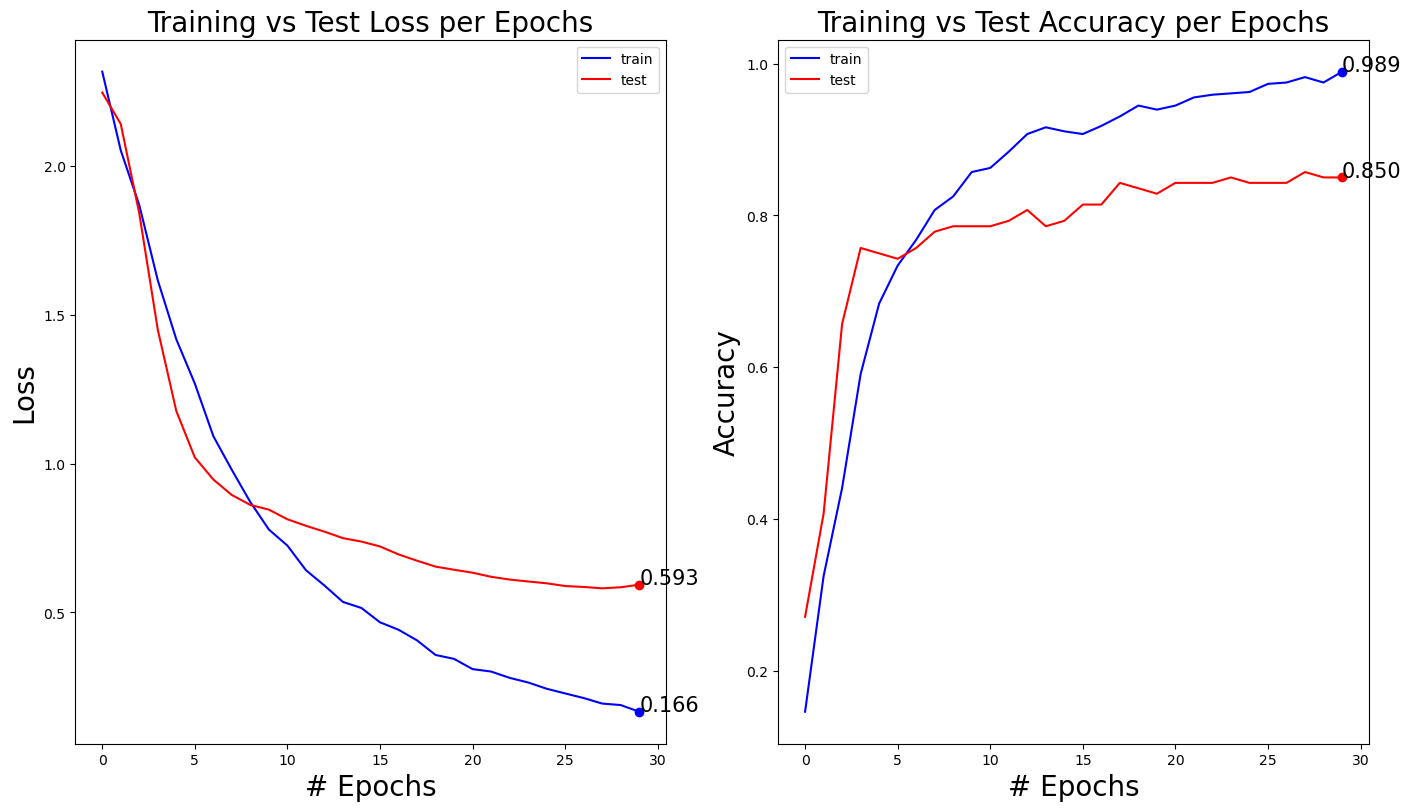

In [351]:
model = FFNN([765, 512, 256, 128, 64, 32, 10], list_p=[0.4, 0.4, 0.2, 0.4, 0.2])
model = model.to(device)
Trainer = FFNNTrainer(model, batch_size=100, learning_rate=1e-3, epoch=30, l1=0, l2=0)
train_loss_all, test_loss_all, train_acc_all, test_acc_all, model = Trainer.train(train_dataset, 
                                                                                       test_dataset, 
                                                                                       draw_curve=True, 
                                                                                       early_stop=True)

Train_dict.update({"FFNN_complex": train_acc_all})
Test_dict.update({"FFNN_complex": test_acc_all})

Considering the overfitting, let's try a simpler architecture with less layer.

100%|██████████| 20/20 [00:00<00:00, 32.33it/s]


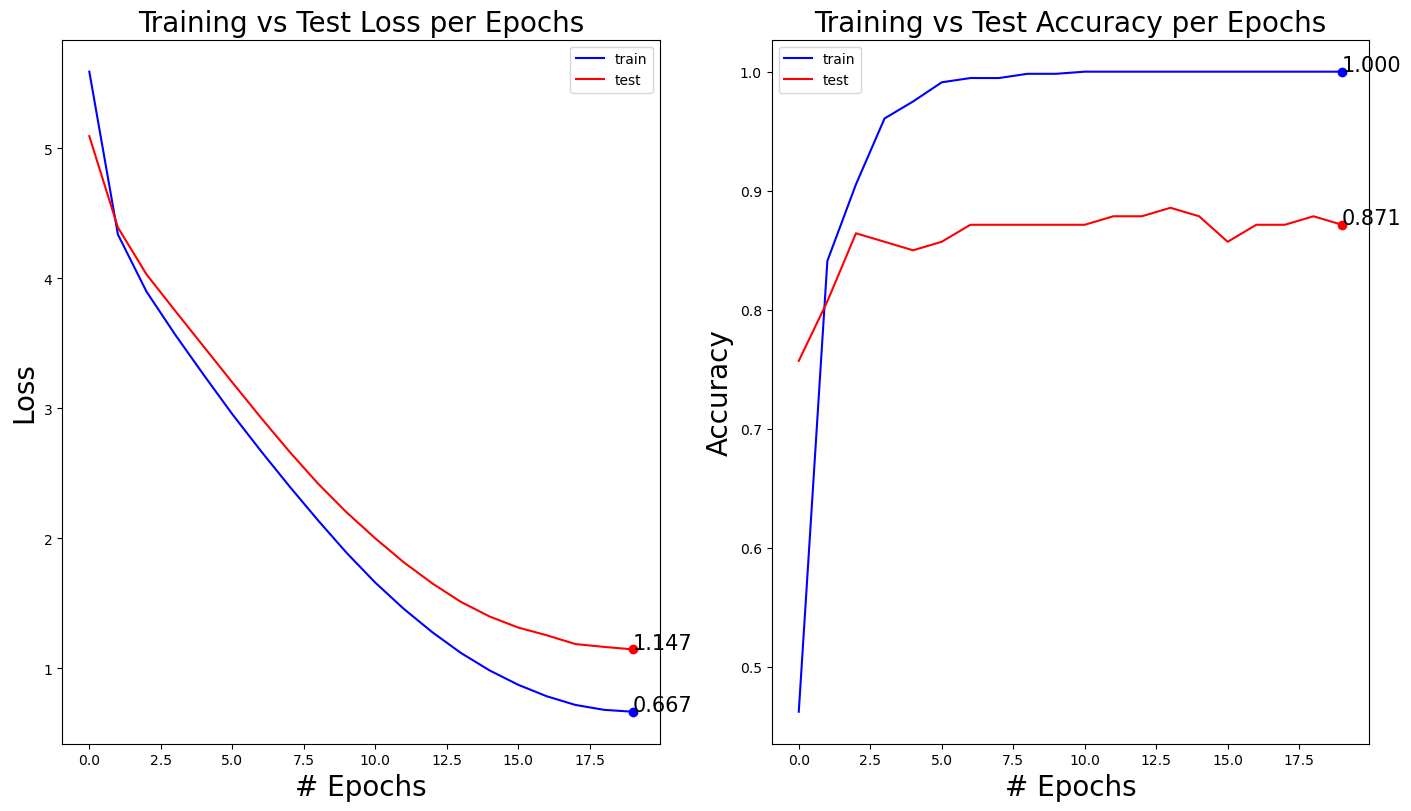

In [355]:
model = FFNN([765, 256, 10], list_p=[0.4])
model = model.to(device)
Trainer = FFNNTrainer(model, batch_size=100, learning_rate=1e-3, epoch=20, l1=1e-3, l2=1e-3)
train_loss_all, test_loss_all, train_acc_all, test_acc_all, model = Trainer.train(train_dataset, 
                                                                                       test_dataset, 
                                                                                       draw_curve=True, 
                                                                                       early_stop=True)
Train_dict.update({"FFNN_simple": train_acc_all})
Test_dict.update({"FFNN_simple": test_acc_all})

The overfitting is still present, but a simpler architecture lead to similar result faster!
Let's try to take into account the imbalancy of the data set by adding class weight.

In [356]:
weight = torch.tensor(class_weight, dtype=torch.float).to(device) * 10
weight

tensor([ 0.6202,  0.3333,  2.5806,  1.1765,  0.8421,  1.4815,  4.2105,  1.8605,
        10.0000,  6.1538], device='cuda:0')

Again let's compare a complex architecture with a simple architecture. 

100%|██████████| 50/50 [00:04<00:00, 10.71it/s]


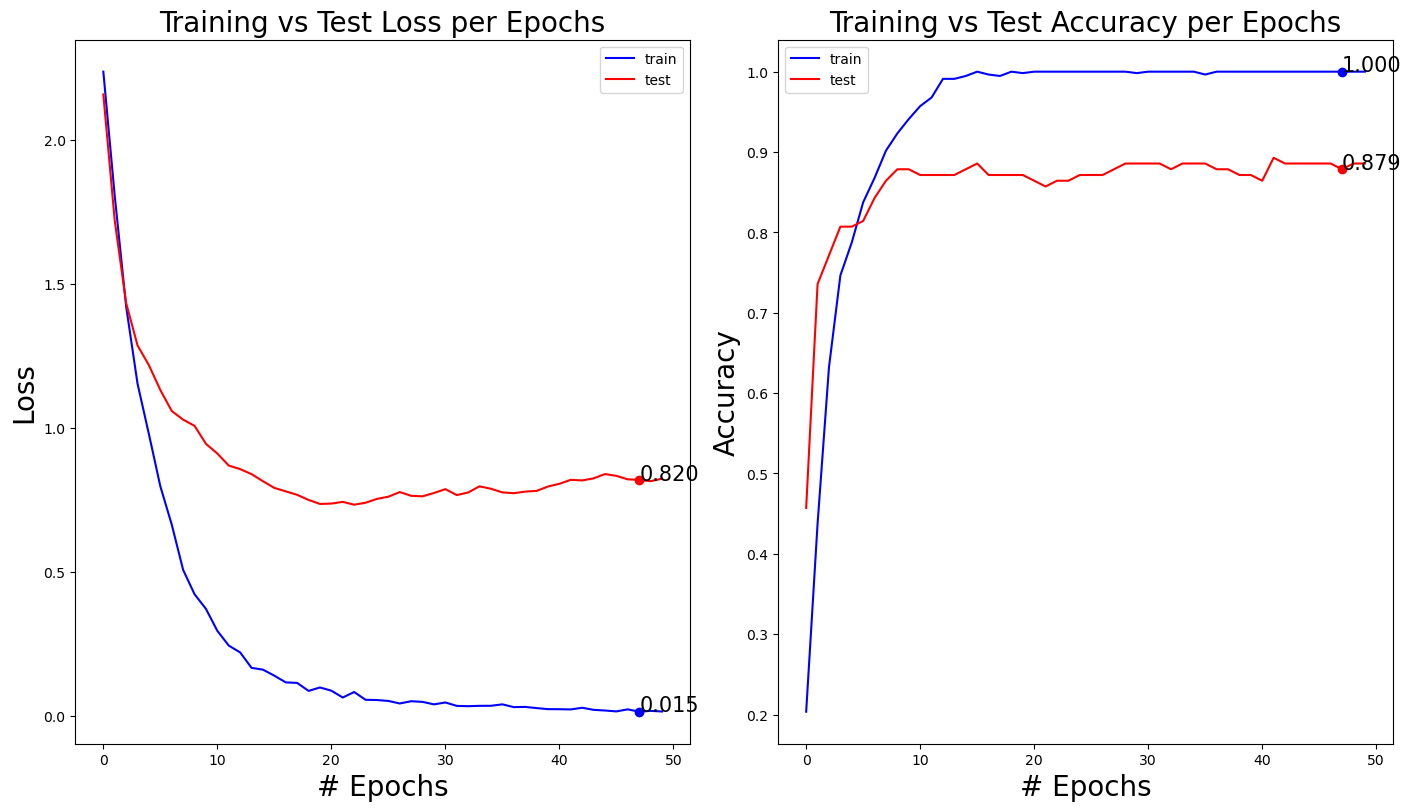

In [357]:
model = FFNN([765, 350, 128, 50, 10], list_p=[0.2, 0.4, 0.4])
model = model.to(device)
Trainer = FFNNTrainer(model, batch_size=50, learning_rate=1e-3, epoch=50, l1=0, l2=1e-4, weight=weight)
train_loss_all, test_loss_all, train_acc_all, test_acc_all, model = Trainer.train(train_dataset, 
                                                                                       test_dataset, 
                                                                                       draw_curve=True, 
                                                                                       early_stop=True)
Train_dict.update({"FFNN_complex_weight": train_acc_all})
Test_dict.update({"FFNN_complex_weight": test_acc_all})

100%|██████████| 20/20 [00:00<00:00, 32.90it/s]


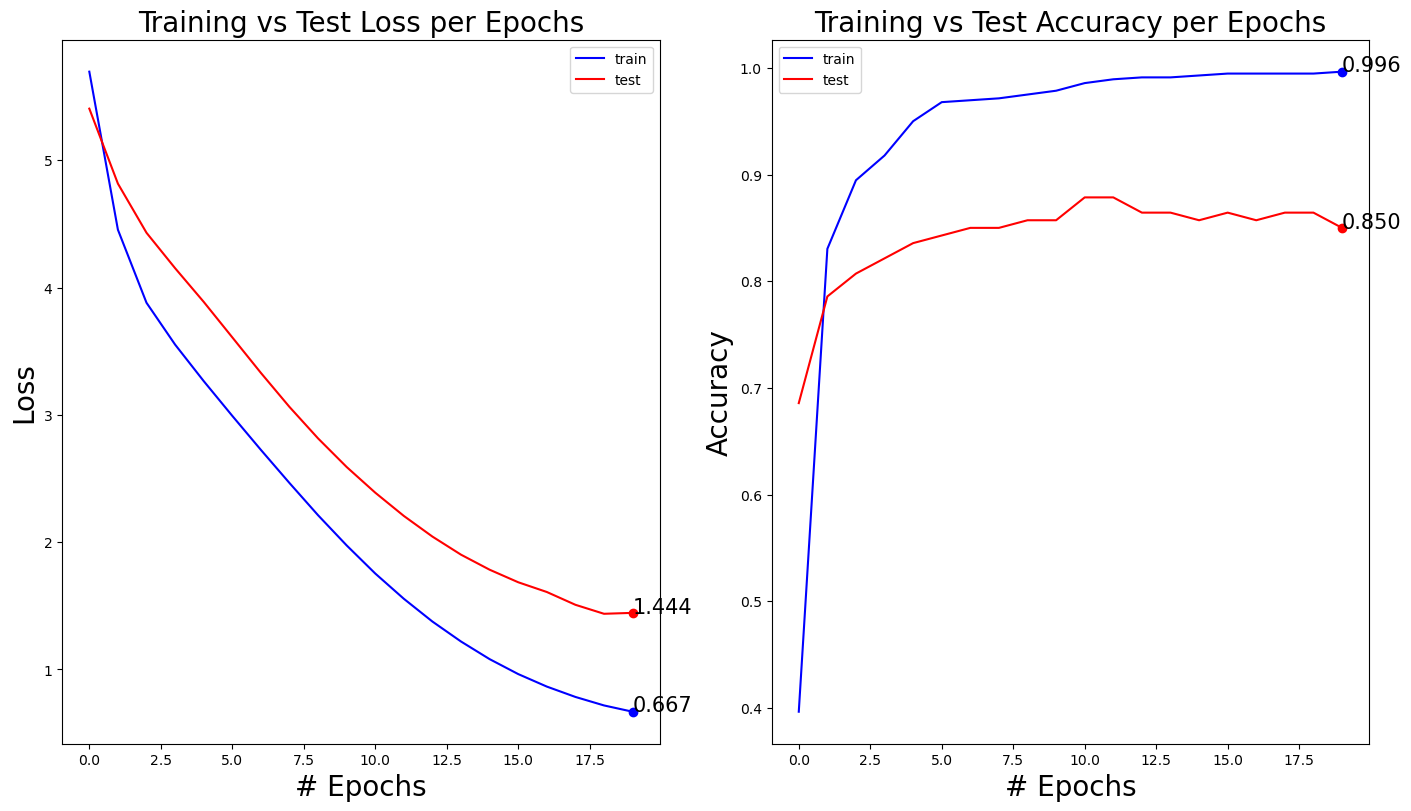

In [369]:
model = FFNN([765, 256, 10], list_p=[0.1])
model = model.to(device)
Trainer = FFNNTrainer(model, batch_size=100, learning_rate=1e-3, epoch=20, l1=1e-3, l2=1e-3, weight=weight)
train_loss_all, test_loss_all, train_acc_all, test_acc_all, model = Trainer.train(train_dataset, 
                                                                                  test_dataset, 
                                                                                  draw_curve=True, 
                                                                                  early_stop=True)
Train_dict.update({"FFNN_simple_weight": train_acc_all})
Test_dict.update({"FFNN_simple_weight": test_acc_all})

# 3) Conclusion <a id="Conclusion"></a>
Let's plot the different accuracy result obtained

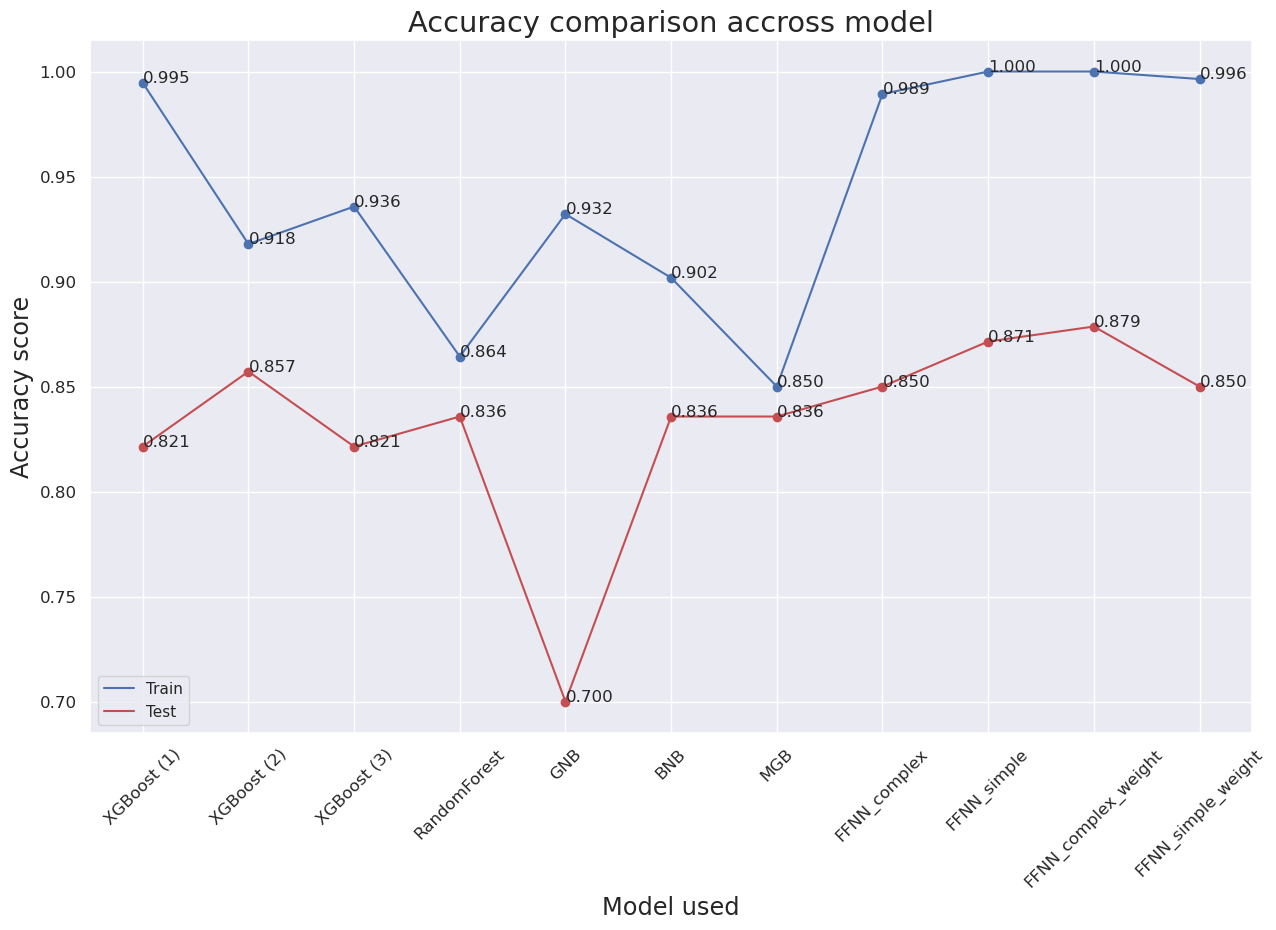

In [420]:
sns.set_theme()
fig = plt.figure(figsize=(15,9))
ax = plt.gca()
sns.lineplot(Train_dict, ax=ax, c='b', label="Train")
sns.lineplot(Test_dict, ax=ax, c='r', label="Test")
ax.scatter(np.arange(len(Train_dict)), list(Train_dict.values()), c='b')
for i, v in enumerate(list(Train_dict.values())):
    ax.annotate(f"{v:0.03f}", (i, v), fontsize=12)

ax.scatter(np.arange(len(Test_dict)), list(Test_dict.values()), c='r')
for i, v in enumerate(list(Test_dict.values())):
    ax.annotate(f"{v:0.03f}", (i, v), fontsize=12)    
    
ax.set_xticks(np.arange(len(Train_dict)), list(Train_dict.keys()), rotation=45, fontsize='medium')
plt.yticks(fontsize='medium')
ax.set_xlabel("Model used", fontsize='x-large')
ax.set_ylabel("Accuracy score", fontsize='x-large')

ax.set_title("Accuracy comparison accross model", fontsize='xx-large')
ax.legend()
plt.show()

When looking at this graph several conclusion can be made: 
+ It happened that the **best test accuracy** obtained is with a **Feed Forward Neural Network (FFNN)** and in particular with the variant with a complex architecture and weight. However FFNN are not deterministic, and their accuracy may vary accross test from ~0.83-0.90. FFNN is however the most difficult to fine-tune and lead to a lot of over-fitting. 
+ **XGBoost** has the advantage to provide a more deterministic solution (accross every test conducted, always the same accuracy for a chosen architecture). In particular the architecture used in XGBoost (2) provide a good trade off in term of Test accuracy and over-fitting. 
+ The **minimum over-fitting** is observed for the **RandomForest** Classifier and the **Multivariate Gaussian Model (MGB) fed with PCA**. MGB present the advantage to be completely deterministic, when random forest may reach various different accuracy from ~0.80-0.84. However, MGB had to be fed with PCA. Therefore, for larger data set with a bigger number of features (there is usually 24,000 genes instead of only 750 here), this method may not be as powerful.  
+ For **Naive Bayes method**, the gaussian one is not good enough, as it overfit too much. Bernouilli is unexpectedly good. It should however be avoided for larger dataset as X features may not be as discrete as in our case.

To conclude on the accurcay comparison for each model, FFNN is the most powerful, Decision Trees gives a fairly good result with a minimum amount of fine tuning, Multivariate Gaussian Bayes fed with PCA is the simplest and lead to still good result.
To fully assess the accuracy of each method, different generation of train / test split should be tested, and each model should be tested several times. 

Thank you for reading! 